In [1]:
import geopandas as gpd
from lu_igi.land_use import LandUse

blocks_gdf = gpd.read_parquet('blocks_probabilities.parquet')
blocks_gdf['land_use'] = blocks_gdf['land_use'].apply(lambda lu : LandUse[lu] if lu is not None else None)
blocks_gdf['probabilities'] = blocks_gdf['probabilities'].apply(lambda p : {LandUse[lu]:p for lu,p in p.items()})
blocks_gdf.head()

,geometry,land_use,area,aspect_ratio,probabilities
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,8.044667e+05,2.194868,"{LandUse.AGRICULTURE: 0.6581908464431763, Land..."
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",LandUse.TRANSPORT,2.317313e+04,15.785508,"{LandUse.AGRICULTURE: 0.006526110228151083, La..."
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",LandUse.RECREATION,3.630058e+05,1.103278,"{LandUse.AGRICULTURE: 0.3287363350391388, Land..."
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",LandUse.RESIDENTIAL,1.964145e+05,2.632707,"{LandUse.AGRICULTURE: 0.0839938297867775, Land..."
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",LandUse.RECREATION,1.781752e+06,1.207539,"{LandUse.AGRICULTURE: 0.38331666588783264, Lan..."


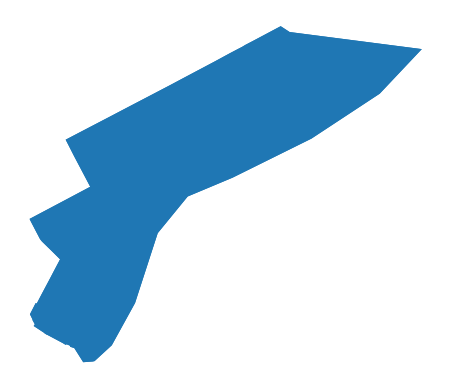

In [2]:
import osmnx as ox

territory_gdf = ox.features_from_place('Санкт-Петербург', tags={'name':'округ № 7'}).to_crs(blocks_gdf.crs) # округ № 7
territory_gdf.plot().set_axis_off()

In [3]:
import networkx as nx

adj_graph = nx.read_graphml('adj_graph.graphml')
nx.relabel_nodes(adj_graph, int, copy=False)

In [4]:
from lu_igi.pygad_optimizer import PygadOptimizer

pygad_optimizer = PygadOptimizer(blocks_gdf, adj_graph)

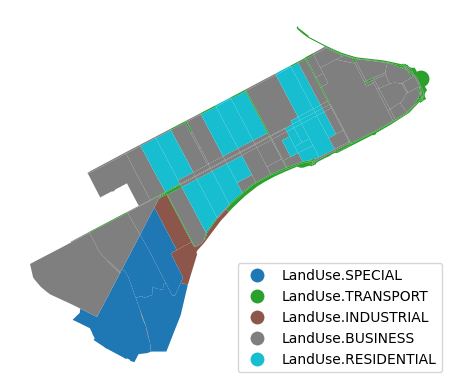

In [5]:
blocks_gdf = blocks_gdf[blocks_gdf.intersects(territory_gdf.union_all())].copy()
blocks_gdf['possible_land_use'] = blocks_gdf['probabilities'].apply(lambda p : max(p, key = p.get))
blocks_gdf.plot(column='possible_land_use', legend=True, legend_kwds={'loc': 'lower right'}).set_axis_off()

In [10]:
target_lu_shares = {
    LandUse.RESIDENTIAL : 0.5,
    LandUse.RECREATION : 0.3,
    LandUse.BUSINESS : 0.2,
    LandUse.AGRICULTURE : 0,
    LandUse.INDUSTRIAL : 0,
    LandUse.SPECIAL : 0,
    LandUse.TRANSPORT : 0
}

blocks_gdf, ga_instance = pygad_optimizer.run(territory_gdf, target_lu_shares, saturation=100, num_generations=100, sol_per_pop=10, mutation_probability=0.5)

  0%|          | 0/100 [00:00<?, ?it/s]/home/vasilstar/lu-igi/.venv/lib/python3.10/site-packages/pygad/pygad.py:1145: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")
100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


In [11]:
blocks_gdf

,geometry,land_use,area,aspect_ratio,probabilities,assigned_land_use
112,"POLYGON ((346701.362 6646318.927, 346685.483 6...",LandUse.INDUSTRIAL,134733.388072,1.775763,"{LandUse.AGRICULTURE: 0.009859737890781723, La...",LandUse.INDUSTRIAL
113,"POLYGON ((348111.757 6647294.345, 348082.192 6...",LandUse.TRANSPORT,27118.318639,8.036589,"{LandUse.AGRICULTURE: 0.00019968856848264844, ...",LandUse.TRANSPORT
114,"POLYGON ((346911.913 6645610.525, 346913.982 6...",LandUse.INDUSTRIAL,191644.467990,1.228675,"{LandUse.AGRICULTURE: 0.005592333145989522, La...",LandUse.SPECIAL
115,"POLYGON ((347274.278 6646250.268, 347204.988 6...",LandUse.RESIDENTIAL,71630.640218,2.843209,"{LandUse.AGRICULTURE: 0.002609127433177682, La...",LandUse.RESIDENTIAL
215,"POLYGON ((346370.186 6645743.047, 346360.572 6...",LandUse.INDUSTRIAL,311087.315399,1.113607,"{LandUse.AGRICULTURE: 0.0030236315575361272, L...",LandUse.INDUSTRIAL
...,...,...,...,...,...,...
9220,"POLYGON ((347828.415 6648117.22, 347826.313 66...",LandUse.TRANSPORT,131.659975,1.318540,"{LandUse.AGRICULTURE: 0.0042141276363112734, L...",LandUse.TRANSPORT
9221,"POLYGON ((348268.048 6648351.304, 348265.568 6...",LandUse.TRANSPORT,952.367235,6.578502,"{LandUse.AGRICULTURE: 0.0039115507063799786, L...",LandUse.TRANSPORT
11105,"POLYGON ((348588.653 6648543.72, 348592.303 66...",LandUse.TRANSPORT,153.958418,3.180366,"{LandUse.AGRICULTURE: 0.00526403978083442, Lan...",LandUse.TRANSPORT
16180,"POLYGON ((346871.489 6645844.206, 346855.702 6...",LandUse.INDUSTRIAL,552.652748,30.797170,"{LandUse.AGRICULTURE: 0.012007766349116749, La...",LandUse.INDUSTRIAL


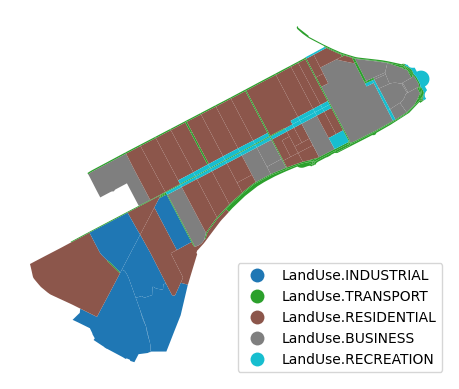

In [12]:
blocks_gdf.plot(column='land_use', legend=True, legend_kwds={'loc': 'lower right'}).set_axis_off()

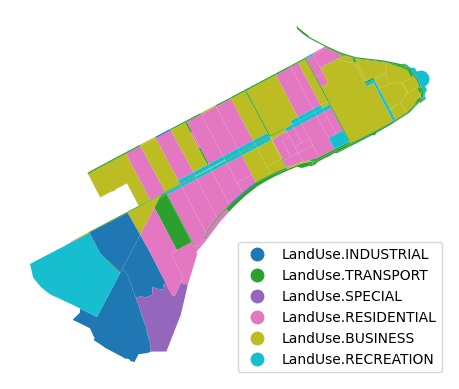

In [13]:
blocks_gdf.plot(column='assigned_land_use', legend=True, legend_kwds={'loc': 'lower right'}).set_axis_off()

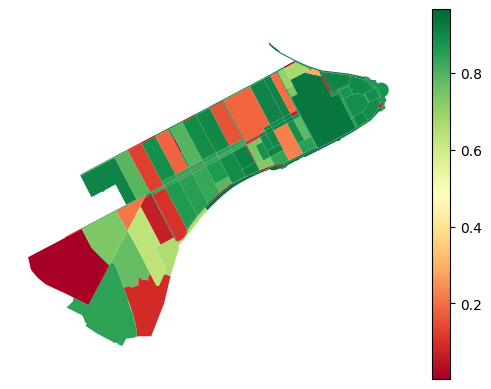

In [14]:
blocks_gdf['probability'] = blocks_gdf.apply(lambda s : s['probabilities'].get(s['assigned_land_use']), axis=1)
blocks_gdf.plot(column='probability', cmap='RdYlGn', legend=True).set_axis_off()

In [15]:
area = blocks_gdf['area'].sum()
for lu in list(LandUse):
    print(lu, round(blocks_gdf[blocks_gdf['assigned_land_use'] == lu]['area'].sum()/area,2))

LandUse.RESIDENTIAL 0.32
LandUse.BUSINESS 0.3
LandUse.RECREATION 0.13
LandUse.SPECIAL 0.05
LandUse.INDUSTRIAL 0.15
LandUse.AGRICULTURE 0.0
LandUse.TRANSPORT 0.06


In [16]:
1/ga_instance.best_solution()[1][0]

0.09826653659999474

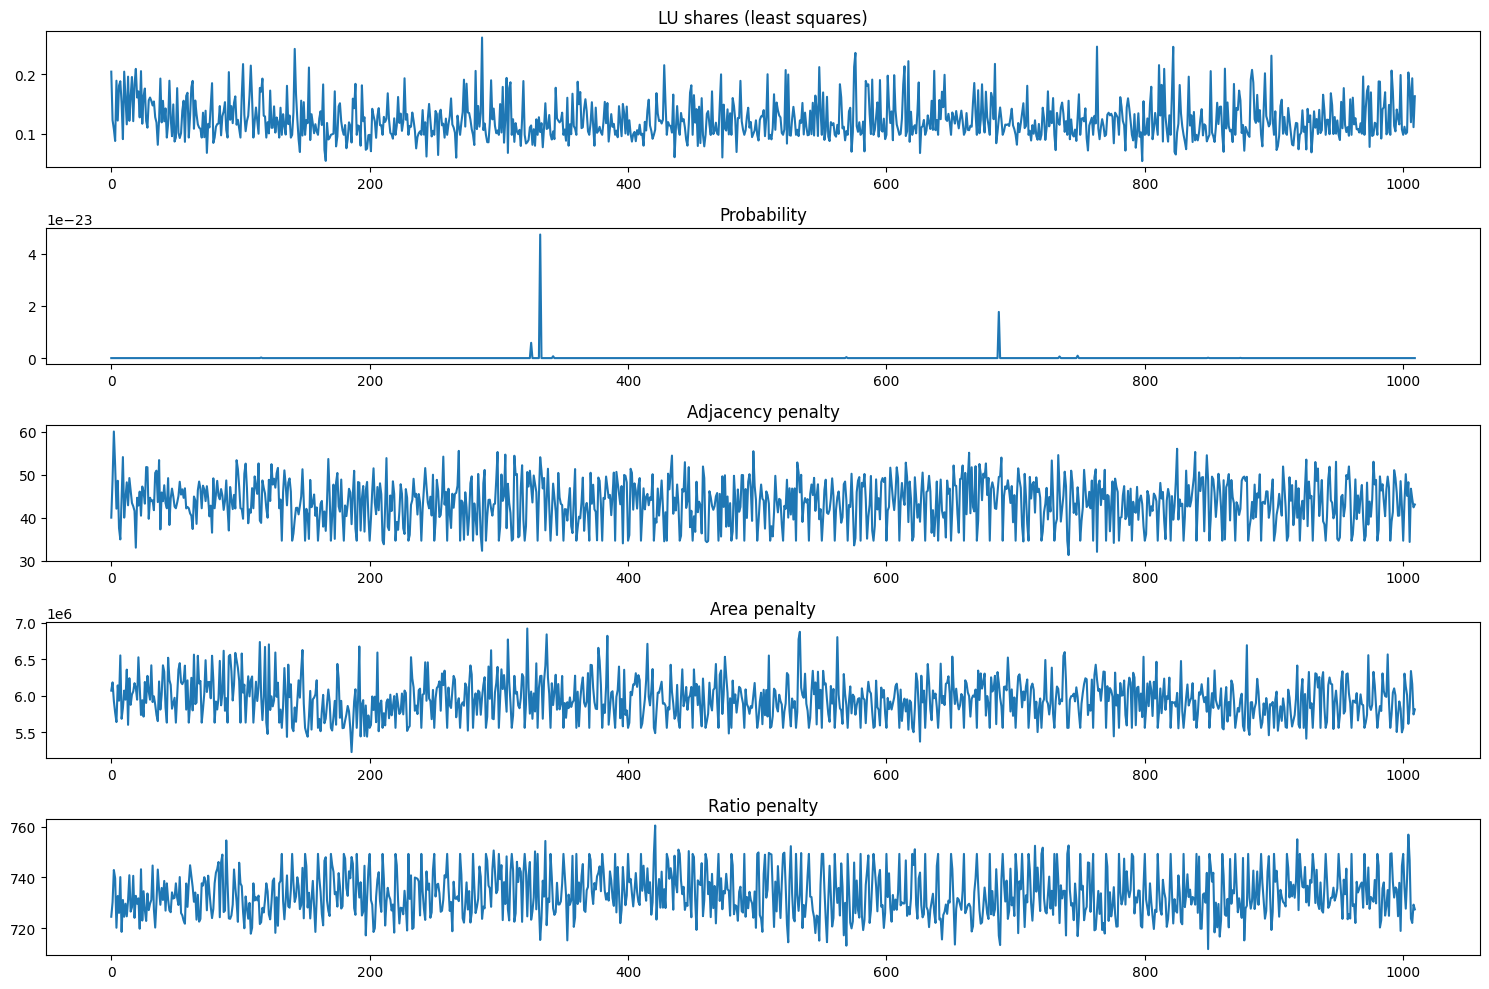

In [17]:
PygadOptimizer.plot_fitness(ga_instance)